In [ ]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = Path("dataset")
IMG_DIR = BASE_DIR / "images"
LBL_DIR = BASE_DIR / "labels"

#### Exploratory Data Analysis

list files

In [ ]:
img_files = sorted([f for f in IMG_DIR.glob("*") if f.suffix.lower() in [".jpg", ".png", ".jpeg"]])
label_files = sorted(LBL_DIR.glob("*.txt"))

Mapping images <-> labels

In [ ]:
img2label = {}
missing_label = []

for img in img_files:
    label_path = LBL_DIR / (img.stem + ".txt")
    if label_path.exists():
        img2label[img.name] = label_path.name  
    else:
        missing_label.append(img.name)

print("\n--- Informasi Dataset ---")
print(f"Total gambar               : {len(img_files)} file")
print(f"Gambar yang memiliki label : {len(img2label)} file")
print(f"Gambar tanpa label         : {len(missing_label)} file")

if missing_label:
    print("\n Contoh gambar tanpa label:")
    for name in missing_label[:10]:
        print("  •", name)



--- Informasi Dataset ---
Total gambar               : 632 file
Gambar yang memiliki label : 632 file
Gambar tanpa label         : 0 file


Analisis Multilabel

In [ ]:
label_count = []
class_freq = Counter()
img_labels = defaultdict(list)

for img_name, lbl_name in img2label.items():
    label_path = LBL_DIR / lbl_name
    
    with open(label_path) as f:
        lines = f.readlines()

    unique_classes = set()
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cid = int(parts[0])
            unique_classes.add(cid)
            img_labels[img_name].append(cid)
            class_freq[cid] += 1

    label_count.append(len(unique_classes))

print("\n--- Statistik Multi-Label per Gambar ---")
print(f"Rata-rata jumlah class per gambar  : {np.mean(label_count):.2f}")
print(f"Minimum jumlah class dalam 1 gambar : {min(label_count)}")
print(f"Maksimum jumlah class dalam 1 gambar: {max(label_count)}")



--- Statistik Multi-Label per Gambar ---
Rata-rata jumlah class per gambar  : 1.51
Minimum jumlah class dalam 1 gambar : 1
Maksimum jumlah class dalam 1 gambar: 4


Label Density Per Class

In [ ]:
print("\n --- Label Density per Class ---")
for cid, cnt in class_freq.items():
    img_total = sum(cid in set(v) for v in img_labels.values())
    avg_density = np.mean([len(set(v)) for v in img_labels.values() if cid in set(v)])
    solo_ratio = sum(len(set(v)) == 1 for v in img_labels.values() if cid in set(v)) / img_total * 100
    
    print(f"\n Class {cid}")
    print(f"  • Muncul pada total anotasi   : {cnt} kali")
    print(f"  • Ada di                      : {img_total} gambar")
    print(f"  • Rata-rata class/image (density saat ada class ini) : {avg_density:.2f}")
    print(f"  • Persentase SOLO label (Gambar dengan hanya 1 class saja)      : {solo_ratio:.2f}%")


 --- Label Density per Class ---

 Class 0
  • Muncul pada total anotasi   : 386 kali
  • Ada di                      : 286 gambar
  • Rata-rata class/image (density saat ada class ini) : 1.91
  • Persentase SOLO label (Gambar dengan hanya 1 class saja)      : 44.41%

 Class 3
  • Muncul pada total anotasi   : 271 kali
  • Ada di                      : 157 gambar
  • Rata-rata class/image (density saat ada class ini) : 2.60
  • Persentase SOLO label (Gambar dengan hanya 1 class saja)      : 9.55%

 Class 2
  • Muncul pada total anotasi   : 344 kali
  • Ada di                      : 279 gambar
  • Rata-rata class/image (density saat ada class ini) : 1.67
  • Persentase SOLO label (Gambar dengan hanya 1 class saja)      : 65.59%

 Class 1
  • Muncul pada total anotasi   : 383 kali
  • Ada di                      : 231 gambar
  • Rata-rata class/image (density saat ada class ini) : 2.02
  • Persentase SOLO label (Gambar dengan hanya 1 class saja)      : 44.59%


Cek imbalance class


 --- Pemeriksaan Imbalance Class ---
   Class ID  Total Anotasi  Jumlah Gambar Mengandung Class
0         0            386                             286
3         1            383                             231
2         2            344                             279
1         3            271                             157


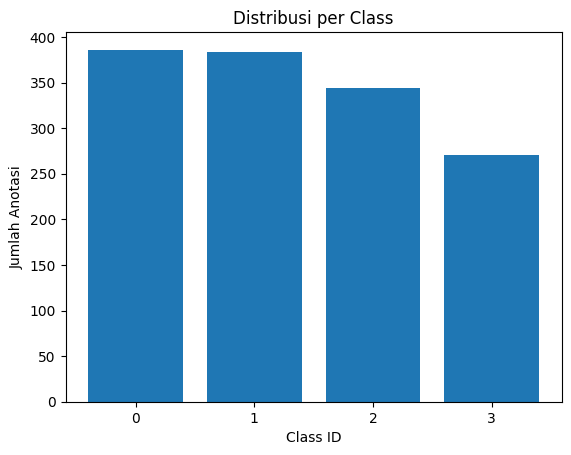

In [ ]:
print("\n --- Pemeriksaan Imbalance Class ---")
df_imb = pd.DataFrame(
    [(cid, cnt, sum(cid in set(v) for v in img_labels.values())) for cid, cnt in class_freq.items()],
    columns=["Class ID", "Total Anotasi", "Jumlah Gambar Mengandung Class"]
).sort_values("Total Anotasi", ascending=False)

print(df_imb)

plt.bar(df_imb["Class ID"].astype(str), df_imb["Total Anotasi"])
plt.title("Distribusi per Class")
plt.xlabel("Class ID")
plt.ylabel("Jumlah Anotasi")
plt.show()

Co-Occurence Matrix
 ( Seberapa sering sebuah class muncul bersamaan dengan class lain dalam gambar yang sama. )

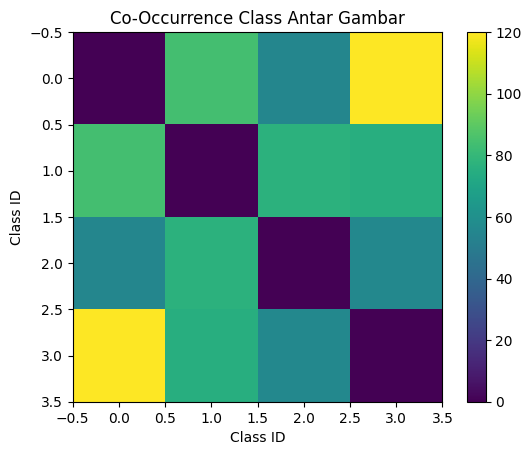

In [ ]:
unique_cids = sorted(class_freq.keys())
co_mat = pd.DataFrame(0, index=unique_cids, columns=unique_cids)

for labels in img_labels.values():
    u = set(labels)
    for a in u:
        for b in u:
            if a != b:
                co_mat.loc[a, b] += 1

plt.imshow(co_mat)
plt.title("Co-Occurrence Class Antar Gambar")
plt.xlabel("Class ID")
plt.ylabel("Class ID")
plt.colorbar()
plt.show()


BOUNDING BOX STATISTICS


--- Statistik Bounding Box (Normalized YOLO) ---
Rata-rata lebar  bbox  : 0.2122
Rata-rata tinggi bbox  : 0.3016
Rata-rata area  bbox  : 0.0927


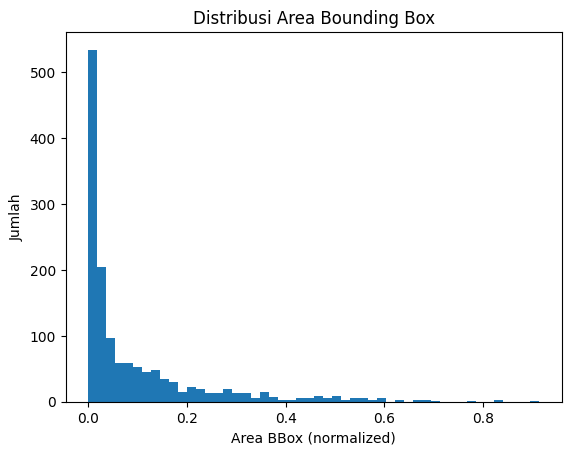

In [ ]:
bbox_w, bbox_h, bbox_area = [], [], []

for lbl in label_files:
    with open(lbl) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, xc, yc, w, h = map(float, parts)
                bbox_w.append(w)
                bbox_h.append(h)
                bbox_area.append(w*h)

print("\n--- Statistik Bounding Box (Normalized YOLO) ---")
print(f"Rata-rata lebar  bbox  : {np.mean(bbox_w):.4f}")
print(f"Rata-rata tinggi bbox  : {np.mean(bbox_h):.4f}")
print(f"Rata-rata area  bbox  : {np.mean(bbox_area):.4f}")

plt.hist(bbox_area, bins=50)
plt.title("Distribusi Area Bounding Box")
plt.xlabel("Area BBox (normalized)")
plt.ylabel("Jumlah")
plt.show()

IMAGE RESOLUTION & ASPECT RATIO

In [ ]:
res_counter = Counter()
aspect_counter = Counter()
corrupt_images = []

for img in img_files:
    try:
        im = Image.open(img)
        w, h = im.size
        res_counter[(w,h)] += 1
        aspect_counter[round(w/h, 2)] += 1
    except:
        corrupt_images.append(img.name)

print("\n--- Resolusi & Rasio Gambar ---")
print("Resolusi paling sering:")
for res, count in res_counter.most_common(5):
    print(f"  • {res} : {count} gambar")

print("\nRasio aspek paling sering:")
for ar, count in aspect_counter.most_common(5):
    print(f"  • {ar} : {count} gambar")


--- Resolusi & Rasio Gambar ---
Resolusi paling sering:
  • (640, 640) : 370 gambar
  • (225, 225) : 28 gambar
  • (700, 700) : 11 gambar
  • (500, 500) : 10 gambar
  • (600, 600) : 10 gambar

Rasio aspek paling sering:
  • 1.0 : 471 gambar
  • 1.5 : 45 gambar
  • 1.78 : 11 gambar
  • 2.0 : 7 gambar
  • 1.33 : 7 gambar


CEK DUPLIKASI GAMBAR DENGAN HASH 

In [ ]:
hash_map = {}
duplicate_imgs = []

for img in img_files:
    try:
        with open(img, "rb") as f:
            img_hash = hashlib.md5(f.read()).hexdigest()
        if img_hash in hash_map:
            duplicate_imgs.append(img.name)
        else:
            hash_map[img_hash] = img.name
    except:
        continue

print("\n --- Pengecekan Duplikasi ---")
print(f"Total gambar duplikat terdeteksi: {len(duplicate_imgs)}")
if duplicate_imgs:
    print("Contoh duplikat:")
    for d in duplicate_imgs[:10]:
        print("  •", d)



 --- Pengecekan Duplikasi ---
Total gambar duplikat terdeteksi: 0
